In [1]:
import cv2
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

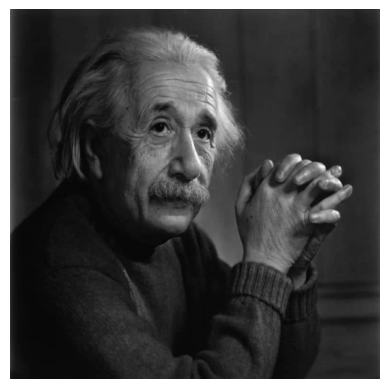

In [2]:
img = cv2.imread('./res/Albert_Einstein.jpg', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (512, 512)) # resize image for convinience

plt.imshow(img, cmap = 'gray')
plt.axis('off')
plt.show()

### Histogram of Oriented Gradients

In [16]:
ORIENTATIONS = 9
CELL_SIZE = 8 # 8x8 pixels
BLOCK_SIZE = 2 # 2x2 cells

ANGLE_STEP = 180 // ORIENTATIONS

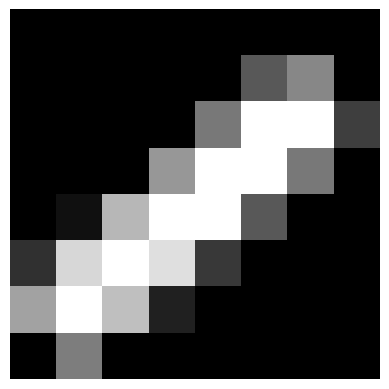

In [17]:
c_hog_lines = []

_im = np.zeros((CELL_SIZE, CELL_SIZE), dtype=np.uint8)
_draw = cv2.line(_im, (0, CELL_SIZE//2 - 1), (CELL_SIZE, CELL_SIZE//2 - 1), 255, 1)
_draw = cv2.line(_im, (0, CELL_SIZE//2), (CELL_SIZE, CELL_SIZE//2), 255, 1)

def _rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
  return result

for i in range(0, 180, ANGLE_STEP):
    c_hog_lines.append(
        _rotate_image(_im, i)
    )

del _im, _draw

plt.imshow(c_hog_lines[2], cmap='gray')
plt.axis('off');

In [18]:
def cell_hist(cell : np.ndarray):
    """
    Compute the histogram for the given cell.
    """

    gx = cell[:, 1:] - cell[:, :-1]
    gy = cell[1:, :] - cell[:-1, :]

    gx = gx[:-1, :]
    gy = gy[:, :-1]

    mags = np.sqrt(gx**2 + gy**2) / 255
    angles = np.rad2deg(np.arctan2(gy, gx)) % 180

    hist = np.zeros(ORIENTATIONS, dtype = np.float32)
    chog_img = np.zeros_like(cell, dtype = np.float32)

    for mag, ang in zip(mags.flatten(), angles.flatten()):
        bin = int(ang // ANGLE_STEP)
        bin_interp = ang / ANGLE_STEP - bin

        hist[bin] += mag * (1 - bin_interp)
        hist[(bin + 1) % ORIENTATIONS] += mag * bin_interp

    for i, c_hog_line in enumerate(c_hog_lines):
        chog_img += c_hog_line * hist[i]

    return hist, chog_img

def hog(img : np.ndarray, gamma : bool = True) -> tuple[np.ndarray, np.ndarray]:
    """
    Compute HOG features for the given Image.
    """

    # Gamma factor reduces effect of light variations.
    if gamma:
        img = np.sqrt(np.array(img).astype(np.float32))
    else:
        img = np.array(img).astype(np.float32)

    hog_img = np.zeros_like(img, dtype = np.float32)
    overall_hist = np.zeros(
        (img.shape[0] // CELL_SIZE, img.shape[1] // CELL_SIZE, ORIENTATIONS),
        dtype = np.float32
    )

    for i in range(0, img.shape[0], CELL_SIZE):
        for j in range(0, img.shape[1], CELL_SIZE):

            sub_img = img[i:i+CELL_SIZE, j:j+CELL_SIZE]

            hist, chog_img = cell_hist(sub_img)
            overall_hist[i//CELL_SIZE, j//CELL_SIZE] = hist
            hog_img[i:i+CELL_SIZE, j:j+CELL_SIZE] = chog_img

    hog_feature = np.zeros(
        (
            img.shape[0] // (CELL_SIZE * BLOCK_SIZE),
            img.shape[1] // (CELL_SIZE * BLOCK_SIZE),
            ORIENTATIONS * BLOCK_SIZE**2
        ),
        dtype = np.float32
    )

    for i in range(0, overall_hist.shape[0], BLOCK_SIZE):
        for j in range(0, overall_hist.shape[1], BLOCK_SIZE):

            block = overall_hist[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE].flatten()
            block /= np.linalg.norm(block) + 1e-6
            hog_feature[i//BLOCK_SIZE, j//BLOCK_SIZE] = block

    return hog_feature, hog_img

HOG Feature extracted shape:  (32, 32, 36)


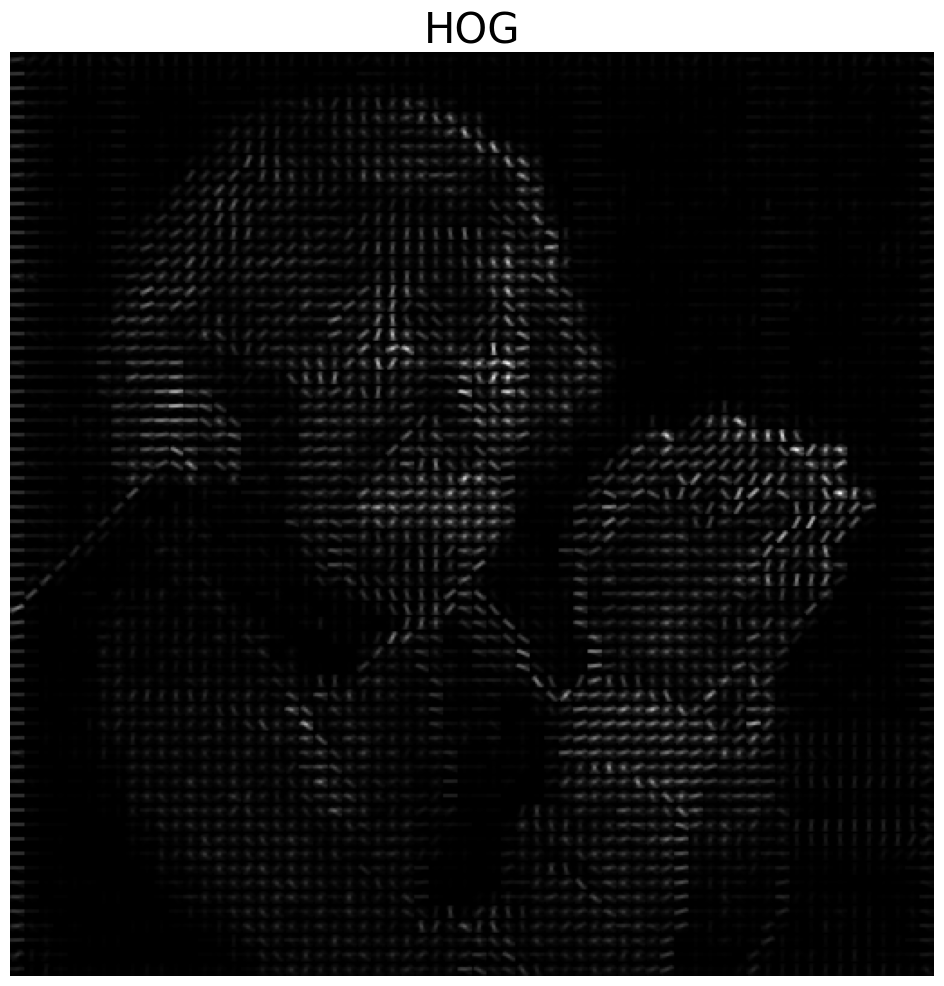

In [19]:
hog_feature, hog_img = hog(img.astype(np.float32))

fig = plt.figure(figsize=(12,12))
plt.title('HOG', fontsize=30)
plt.imshow(hog_img, cmap='gray')
fig.get_axes()[0].set_axis_off()

print("HOG Feature extracted shape: ", hog_feature.shape)

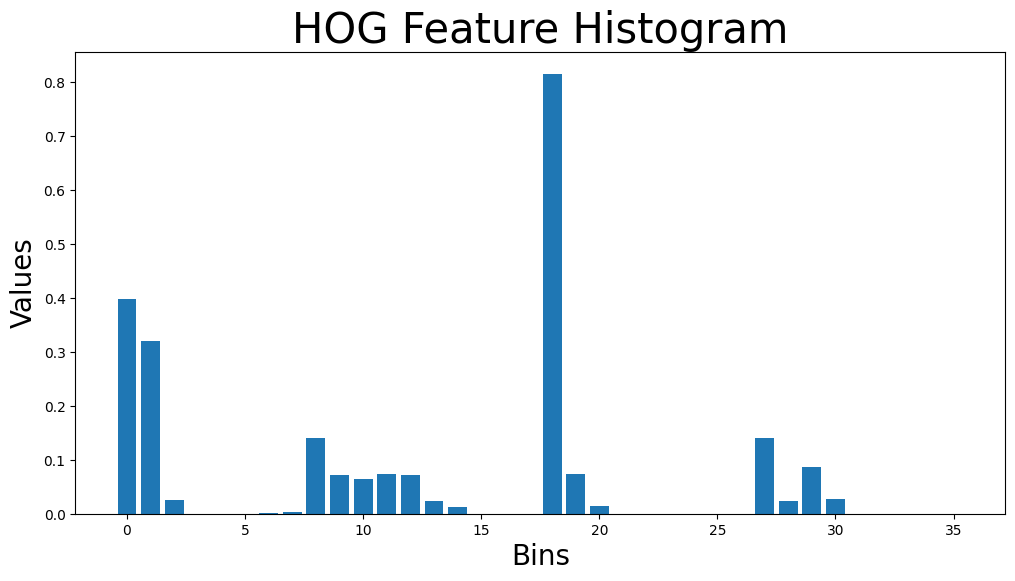

In [20]:
fig = plt.figure(figsize=(12,6))
plt.title('HOG Feature Histogram', fontsize=30)
plt.bar(range(ORIENTATIONS * BLOCK_SIZE ** 2), hog_feature[0,0])
plt.xlabel('Bins', fontsize=20)
plt.ylabel('Values', fontsize=20)

plt.show();

### SIFT

#### Gaussian blur

In [3]:
@jit
def _filter2d(
    image : np.ndarray, filter : np.ndarray,
    padding_x : int, padding_y : int) -> np.ndarray:
    '''
    This function uses JIT compilation supported functions only to give
    huge boost in performance. We are talking about around 10x speedup here.
    '''

    filtered_image = np.zeros(
        (image.shape[0] - 2 * padding_x, image.shape[1] - 2 * padding_y), dtype=np.float32
    )

    for i in range(padding_x, image.shape[0] - padding_x):
        for j in range(padding_y, image.shape[1] - padding_y):
            img_chunk = image[i-padding_x:i+padding_x+1, j-padding_y:j+padding_y+1]
            filtered_image[i - padding_x, j - padding_y] = np.sum(filter * img_chunk)

    return filtered_image


def filter2d(image : np.ndarray, filter : np.ndarray) -> np.ndarray:
    '''
    This function applies a 2D square filter with odd dimensions to an image.
    '''

    if filter.shape[0] % 2 == 0:
        raise ValueError("Filter must have odd dimensions")

    padding_x = filter.shape[0] // 2
    padding_y = filter.shape[0] // 2
    padded_image = np.pad(image, (padding_x, padding_y), mode = 'edge')

    return _filter2d(padded_image, filter, padding_x, padding_y)


def gaussian_blur(image : np.ndarray, sigma : float) -> np.ndarray:
    """Apply Gaussian blur with a given sigma."""
    ksize = int(2 * np.ceil(np.pi * sigma / 2) + 1)

    kernels = np.arange(-ksize//2, ksize//2 + 2)
    kern_grid = np.zeros((ksize, ksize))

    for i in range(ksize):
        for j in range(ksize):
            kern_grid[i, j] = kernels[i]**2 + kernels[j]**2

    gaussian_filter = 1 / (2 * np.pi * sigma**2) * np.exp(
        -.5 * kern_grid / sigma**2
    )

    return filter2d(image, gaussian_filter)

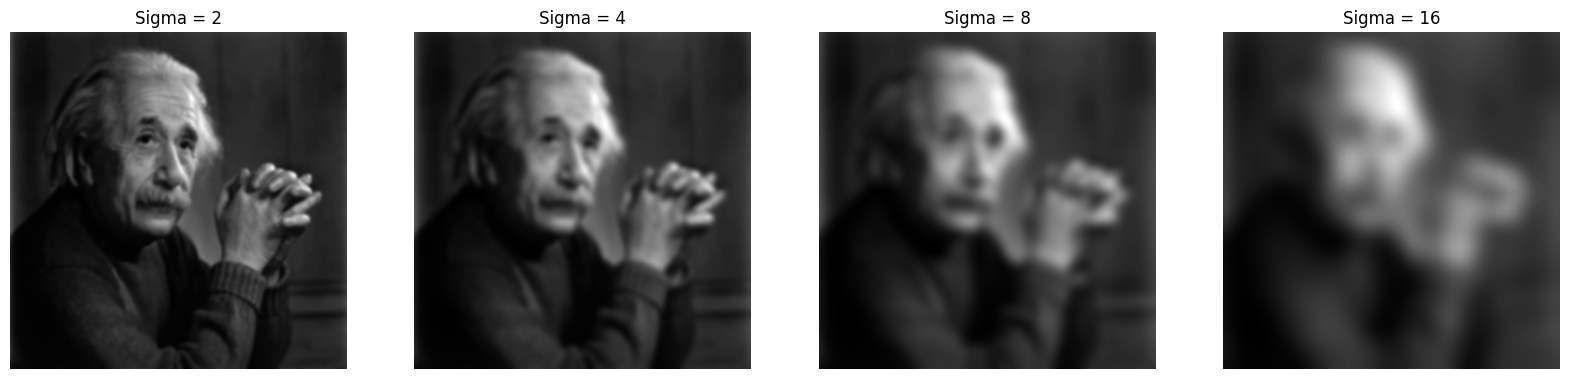

In [4]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

for i, sigma in enumerate([2, 4, 8, 16]):
    im_small = cv2.resize(img, (512//(2**i), 512//(2**i)))
    blurred = gaussian_blur(im_small, sigma//(2**i))
    blurred = cv2.resize(blurred, (512, 512))
    axes[i].imshow(blurred, cmap='gray')
    axes[i].set_title(f'Sigma = {sigma}')
    axes[i].axis('off')

#### Interest points

In [5]:
INIT_SIGMA = 2
NUM_OCTAVES = 3
NUM_SCALES = 4
SCALE_MULTIPLIER = 2**(1/4)

In [6]:
def gaussian_pyramid(image : np.ndarray) -> list[np.ndarray]:
    """Generate a Gaussian pyramid for the image."""

    gaussian_pyramid = []

    for o in range(NUM_OCTAVES):
        gaussian_layers = []
        sigma = INIT_SIGMA * 2 ** o

        for _ in range(NUM_SCALES):
            gaussian_layers.append(gaussian_blur(image, sigma))
            sigma *= SCALE_MULTIPLIER

        gaussian_pyramid.append(np.asarray(gaussian_layers))
        image = cv2.resize(image, (image.shape[1]//2, image.shape[0]//2))

    return gaussian_pyramid


def dog_pyramid(gaussian_layers : list[np.ndarray]) -> np.ndarray:
    """Generate the Difference of Gaussian (DoG) pyramid."""

    dog_octaves = []

    for o in range(NUM_OCTAVES):
        dog_layers = []

        for i in range(1, len(gaussian_layers[o])):
            dog_layers.append(gaussian_layers[o][i] - gaussian_layers[o][i-1])

        dog_octaves.append(np.asarray(dog_layers))

    return dog_octaves


@jit
def is_extrema(patch : np.ndarray, threshold : float) -> bool:
    """Check if the value is a local extrema in 3D space."""

    patch = np.abs(patch)
    center = patch[1, 1]

    if center > threshold and center == np.max(patch):
        return True

    return False


@jit
def find_keypoints(dog_octaves : list[np.ndarray], threshold : float = 10.) -> list[tuple[int, int, int]]:
    """Detect keypoints by finding local extrema in DoG pyramid."""

    keypoints = []
    sigma = INIT_SIGMA

    for o, dog_octave in enumerate(dog_octaves):
        for dog_layer in dog_octave:

            r = int(sigma * np.pi)
            for x in range(1, dog_layer.shape[0] - 1):
                for y in range(1, dog_layer.shape[1] - 1):

                    patch = dog_layer[x-1:x+2, y-1:y+2]

                    if is_extrema(patch, threshold):
                        keypoints.append((x * (2 ** o), y * (2 ** o), r))

            sigma *= SCALE_MULTIPLIER

        sigma = INIT_SIGMA * 2 ** (o + 1)

    return keypoints

In [7]:
gauss_pyr = gaussian_pyramid(img)
dog_pyr = dog_pyramid(gauss_pyr)

In [8]:
keypoints = find_keypoints(dog_pyr, 10)

print(f'Keypoints detected: {len(keypoints)}')

Keypoints detected: 229


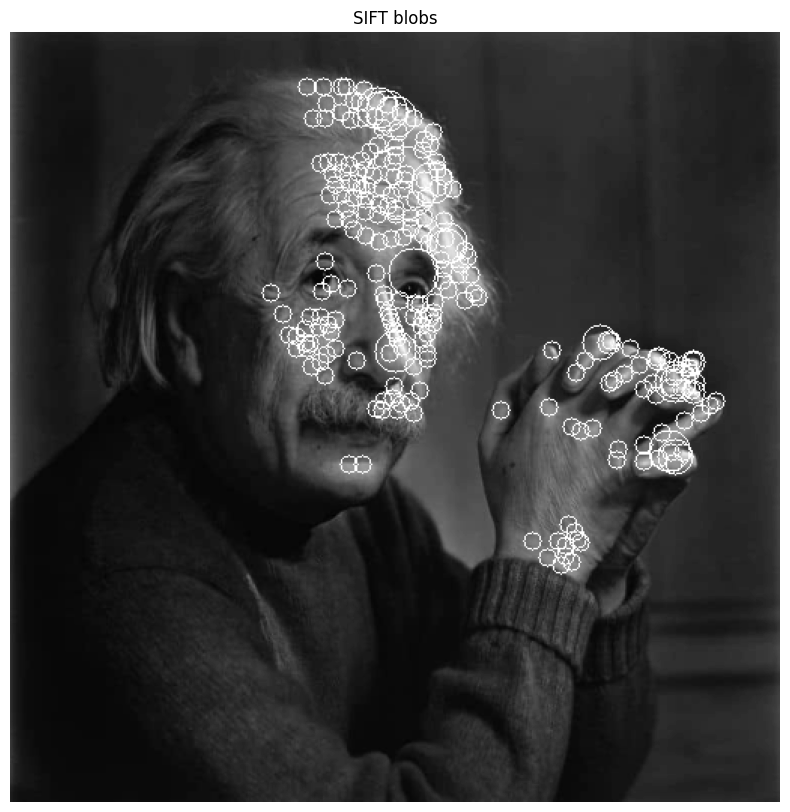

In [9]:
sift_img = img.copy()

for x, y, r in keypoints:
    cv2.circle(sift_img, (y, x), int(r), 255, 1)

fig = plt.figure(figsize=(10, 10))
plt.imshow(sift_img, cmap = 'gray')
plt.title("SIFT blobs")
fig.get_axes()[0].set_axis_off()

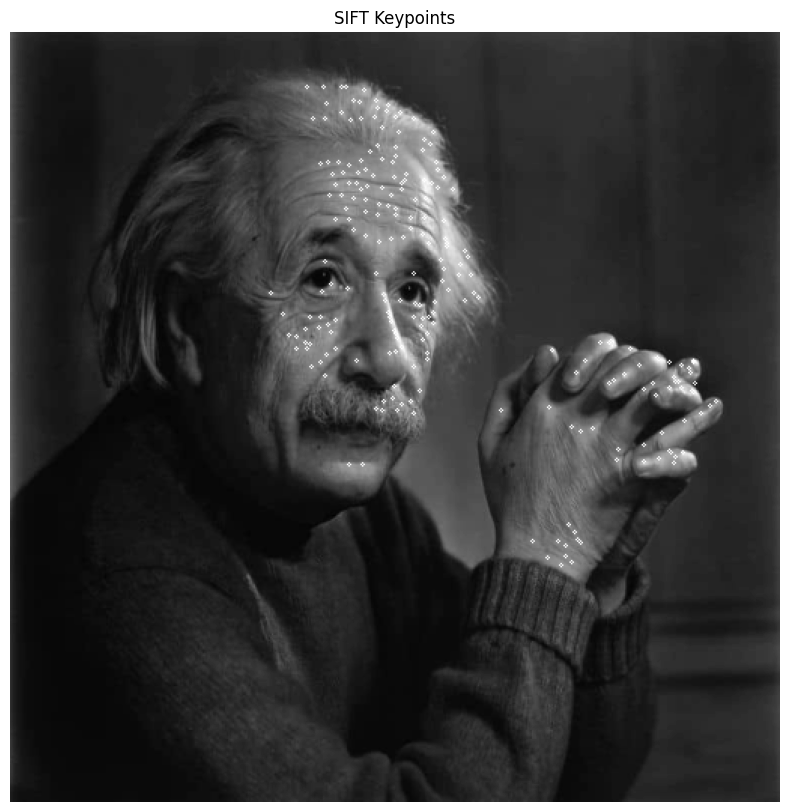

In [10]:
sift_img = img.copy()

for x, y, r in keypoints:
    cv2.circle(sift_img, (y, x), 1, 255, 1)

fig = plt.figure(figsize=(10, 10))
plt.imshow(sift_img, cmap = 'gray')
plt.title("SIFT Keypoints")
fig.get_axes()[0].set_axis_off()

### Bag of Words

In [11]:
NUM_WORDS = 8
WORD_SIZE = 4 # 8x8 pixels

In [12]:
words = []

np.random.seed(0)
for _ in range(NUM_WORDS):
    x = int(np.random.randint(0, img.shape[0] - WORD_SIZE))
    y = int(np.random.randint(0, img.shape[0] - WORD_SIZE))
    words.append(img[x:x+WORD_SIZE, y:y+WORD_SIZE])

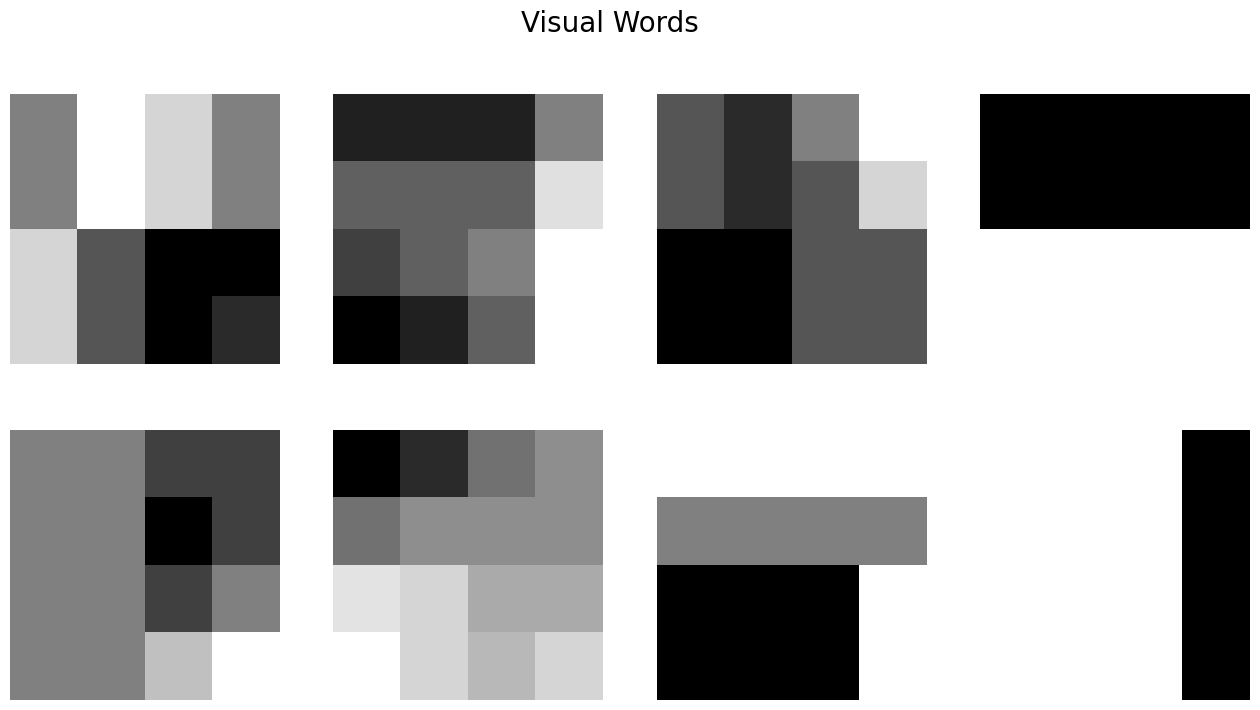

In [13]:
fig, axes = plt.subplots(2, _:=NUM_WORDS // 2 + NUM_WORDS % 2, figsize=(4*_, 8))

for i, word in enumerate(words):
    axes[i // 4, i % 4].imshow(word, cmap='gray')
    axes[i // 4, i % 4].axis('off')

fig.suptitle('Visual Words', fontsize = 20)
plt.show()

In [14]:
def compute_bow(image : np.ndarray, word : list[np.ndarray], dist_threshold : float = 20) -> np.ndarray:
    """
    Detect the presence of a visual word in the image.
    """

    word_size = WORD_SIZE
    word_flattened = [w.flatten() for w in word]
    word_hist = np.zeros(len(words), dtype = np.float32)

    for i in range(0, image.shape[0], word_size):
        for j in range(0, image.shape[1], word_size):

            sub_img = image[i:i+word_size, j:j+word_size]
            sub_img = sub_img.flatten()

            for k, w in enumerate(word_flattened):
                if np.linalg.norm(sub_img - w) < dist_threshold:
                    word_hist[k] += 1

    return word_hist

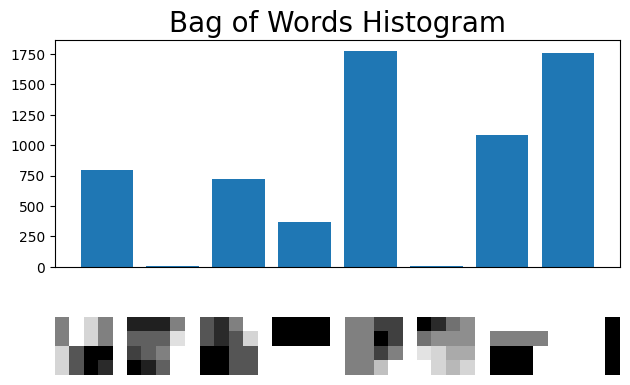

In [15]:
bow_hist = compute_bow(img, words, 30)

plt.subplot2grid((2, len(words)), (0, 0), colspan=len(words))\
    .get_xaxis().set_visible(False)
plt.bar(range(len(words)), bow_hist)
plt.title('Bag of Words Histogram', fontsize=20)

for i in range(len(words)):
    plt.subplot2grid((2, len(words)), (1, i))
    plt.imshow(words[i], cmap='gray')
    plt.axis('off')

plt.tight_layout()
plt.show();